In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange

In [38]:
dataset = pd.read_table("verb_veridicality.tsv")
dataset.head()

,index,task,verb,sentence,neg_sentence,complement,turker_pos_ratings,turker_neg_ratings,bert_pos_entailment_prob,bert_pos_contradiction_prob,bert_pos_neutral_prob,bert_neg_entailment_prob,bert_neg_contradiction_prob,bert_neg_neutral_prob,signature
0,0,to,move,"Fearing that overdevelopment, as well as new t...","Fearing that overdevelopment, as well as new t...","Fearing that overdevelopment, as well as new t...","1.0,2.0,2.0","-2.0,-2.0,-2.0",0.998875,0.000317,0.000807,0.000299,0.999224,0.000477,o/o
1,1,to,decline,Nike declined to be a sponsor.,Nike did not decline to be a sponsor.,Nike was a sponsor.,"-2.0,-2.0,1.0","0.0,0.0,1.0",0.000543,0.998916,0.000542,0.996050,0.000405,0.003545,-/o
2,2,to,intend,I intend to resume the habit as a delight of o...,I do not intend to resume the habit as a delig...,I resume the habit as a delight of old.,"-2.0,1.0,1.0","0.0,0.0,0.0",0.997368,0.000648,0.001984,0.000256,0.999205,0.000540,o/o
3,3,to,intend,Ashoka intended to use this power to control p...,Ashoka did not intend to use this power to con...,Ashoka used this power to control people.,"0.0,0.0,1.0","-1.0,0.0,0.0",0.995333,0.001741,0.002926,0.000586,0.998603,0.000811,o/o
4,4,to,intend,Yesterday I said that I intended to live by my...,Yesterday I said that I did not intend to live...,Yesterday i said that i lived by my wits.,"0.0,1.0,2.0","-2.0,-2.0,0.0",0.997938,0.000746,0.001316,0.000226,0.999453,0.000322,o/o


In [51]:
verbs = dataset['verb']
signs = dataset['signature']
datas = [(verbs[i], signs[i]) for i in range(len(verbs))]
datas = set(datas)

In [52]:
df = pd.DataFrame(list(datas), columns =['Verb', 'Signature'])

In [54]:
df.to_csv("verb_veridicality.csv")

In [34]:

data = pd.read_csv("../data/ner_dataset.csv", encoding="latin1").fillna(method="ffill")
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [3]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None


In [4]:
getter = SentenceGetter(data)
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[0]

['Thousands',
 'of',
 'demonstrators',
 'have',
 'marched',
 'through',
 'London',
 'to',
 'protest',
 'the',
 'war',
 'in',
 'Iraq',
 'and',
 'demand',
 'the',
 'withdrawal',
 'of',
 'British',
 'troops',
 'from',
 'that',
 'country',
 '.']

In [5]:
labels = [[s[2] for s in sentence] for sentence in getter.sentences]
print(labels[0])
tag_values = list(set(data["Tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


In [6]:
import torch
import transformers
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig, RobertaTokenizer
from transformers import RobertaForTokenClassification, AdamW
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


'1.7.0'

In [7]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'
MAX_LEN = 75
bs = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla K80'

In [8]:
#tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [9]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [10]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)-
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [11]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [13]:
model = RobertaForTokenClassification.from_pretrained(
    "roberta-base",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)
model.cuda()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able

RobertaForTokenClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((7

In [14]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [15]:
from transformers import get_linear_schedule_with_warmup

epochs = 3
max_grad_norm = 1.0

total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [16]:
from seqeval.metrics import f1_score, accuracy_score

In [19]:
loss_values, validation_loss_values = [], []

for i in tqdm(range(epochs)):
    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        model.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        print("Local Loss: ", loss)
        loss.backward()
        total_loss += loss.item()
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    loss_values.append(avg_train_loss)

    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()


  0%|          | 0/3 [00:00<?, ?it/s]

Local Loss:  tensor(0.3053, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1939, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.2264, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.2361, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.2303, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.2096, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1480, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.2018, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.2706, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.2000, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.2609, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.3043, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1814, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.2080, device='cuda:0', grad_fn=<NllLossBac

Local Loss:  tensor(0.1778, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.2097, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1783, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1290, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1953, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1018, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1830, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1210, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1512, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1374, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1570, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1649, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1794, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1629, device='cuda:0', grad_fn=<NllLossBac

Local Loss:  tensor(0.1827, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1565, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1309, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.2433, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.0949, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.2385, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.2971, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.2129, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.2125, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1041, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.2015, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1571, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1991, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.2210, device='cuda:0', grad_fn=<NllLossBac

Local Loss:  tensor(0.1817, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1745, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.2261, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1343, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1715, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1355, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1575, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1281, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1383, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.2215, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1980, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.0901, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1030, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.2521, device='cuda:0', grad_fn=<NllLossBac

Local Loss:  tensor(0.1304, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1220, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1960, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.2109, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1102, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1589, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.0993, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1889, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1645, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1328, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1747, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.0985, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1439, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1406, device='cuda:0', grad_fn=<NllLossBac

Local Loss:  tensor(0.1554, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.0936, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1586, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.0790, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.2153, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1136, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1207, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.0963, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1338, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.2808, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1843, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1713, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1788, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1415, device='cuda:0', grad_fn=<NllLossBac

Local Loss:  tensor(0.1892, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1609, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1006, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1518, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1324, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1245, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.2316, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1431, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1666, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1569, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1285, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1574, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1297, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.2022, device='cuda:0', grad_fn=<NllLossBac

Local Loss:  tensor(0.1042, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1329, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1600, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1929, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.2089, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1984, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1555, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.0647, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.2081, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1002, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1502, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.0860, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.2251, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1196, device='cuda:0', grad_fn=<NllLossBac

Local Loss:  tensor(0.1241, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1416, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1565, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1226, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.0838, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1866, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.0938, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1486, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.2144, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1034, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1604, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1310, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1275, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1852, device='cuda:0', grad_fn=<NllLossBac

Local Loss:  tensor(0.1321, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.0855, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1326, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1793, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.2227, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1493, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.2684, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1553, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1013, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.0761, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1289, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1683, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1158, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1361, device='cuda:0', grad_fn=<NllLossBac

Local Loss:  tensor(0.1865, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.3265, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.0982, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1626, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1124, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1427, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1541, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.0921, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1982, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1346, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1380, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1068, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1455, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1282, device='cuda:0', grad_fn=<NllLossBac

Local Loss:  tensor(0.1135, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1124, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1054, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1243, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1453, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.0834, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1866, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1174, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1547, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1656, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.2168, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.0981, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1325, device='cuda:0', grad_fn=<NllLossBackward>)
Local Loss:  tensor(0.1868, device='cuda:0', grad_fn=<NllLossBac

  0%|          | 0/3 [19:29<?, ?it/s]

Validation loss: 0.13975810597340266
Validation Accuracy: 0.9567322861650319


TypeError: Found input variables without list of list.

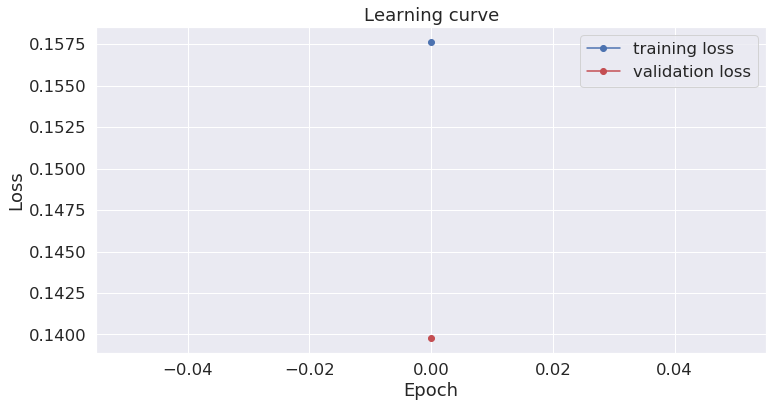

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [28]:
test_sentence = "Mr. Trump’s tweets began just moments after a Fox News report by Mike Tobin, a" + \
"reporter for the network, about protests in Minnesota and elsewhere. "

In [29]:
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()

In [30]:
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

In [31]:
# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

In [32]:
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

O	<s>
B-per	Mr
B-per	.
I-per	ĠTrump
O	âĢ
O	Ļ
O	s
O	Ġtweets
O	Ġbegan
O	Ġjust
O	Ġmoments
O	Ġafter
O	Ġa
B-org	ĠFox
B-org	ĠNews
O	Ġreport
O	Ġby
B-per	ĠMike
I-per	ĠTob
I-per	in
O	,
O	Ġare
O	porter
O	Ġfor
O	Ġthe
O	Ġnetwork
O	,
O	Ġabout
O	Ġprotests
O	Ġin
B-geo	ĠMinnesota
O	Ġand
O	Ġelsewhere
O	.
O	Ġ
O	</s>
